In [1]:
import pandas as pd
import pymc as pm
import arviz as az
from tqdm.auto import tqdm  # Substitui o tqdm padrão

# Carregar dados
data = pd.read_excel(r'DADOS BRUTOS/ECQ_ABR_25.xlsx', sheet_name='Export')
data = data[data['ANF'] == 83]
#data = data.query("MUNICIPIO in ['CAMPINA GRANDE', 'PATOS', 'JOAO PESSOA']")
data['TESTES_ECQ_OK'] = (data['TESTES_ECQ'] * data['ECQ']).round(0).astype(int)


/home/tiago/anaconda3/envs/pymc_env/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
data.columns

Index(['REGIONAL', 'UF', 'ANF', 'ARQUETIPO', 'MUNICIPIO', 'FAIXA POPULACIONAL',
       'CLASSIFICACAO_GSBI', 'ENDERECO_ID', 'ECQ', 'CCQ', 'RELIABILITY',
       'ECQ_KPI', 'DOWNLOAD', 'PERDAS_DOWNLOAD', 'UPLOAD', 'PERDAS_UPLOAD',
       'LATENCIA', 'PERDAS_LATENCIA', 'JITTER', 'PERDAS_JITTER', 'FIRSTBYTE',
       'PERDAS_FIRSTBYTE', 'PKTLOSS', 'PERDAS_PKTLOSS', 'PKTLOSS_DISCARD',
       'PERDAS_PKTLOSS_DISCARD', 'TESTES_ECQ', '% Peso Perdas Total',
       '% Peso Perdas Download', '% Peso Perdas Upload',
       '% Peso Perdas FirstByte', '% Peso Perdas Jitter',
       '% Peso Perdas Latencia', '% Peso Perdas Packtloss',
       '% Peso Perdas PcktlossDescarte', 'IncECQ', 'TESTES_ECQ_OK'],
      dtype='object')

In [3]:

# Agrupar por ANF e Município (DEFINA AQUI)
grouped = data.groupby(['ANF', 'MUNICIPIO'])

with pm.Model() as modelo_flex_phi_estimado:
    # Hiperpriors para ANFs (Nível 3)
    anfs = data['ANF'].unique()
    n_anfs = len(anfs)

    # Hiperprior global
    mu_global = pm.Beta("mu_global", 2, 2)
    sigma_global = pm.HalfNormal("sigma_global", 0.1)
    
#    mu_anf = pm.Beta("mu_anf", alpha=2, beta=2, shape=n_anfs)
    mu_anf = pm.Beta("mu_anf",
                alpha=mu_global * sigma_global,
                beta=(1 - mu_global) * sigma_global,
                shape=n_anfs)

    # Phi estimado para municípios e sites
    phi_municipio = pm.HalfNormal("phi_municipio", sigma=10)  # Nível 2
    phi_site = pm.HalfNormal("phi_site", sigma=10)            # Nível 1
    
    # Mapeamento ANF -> índice
    anf_id_map = {anf: idx for idx, anf in enumerate(anfs)}
    
    # Loop por cada grupo (ANF + Município)
    theta_sites_list = []
    for (anf, municipio), group in grouped:
        # Dados do município
        n_tests = group['TESTES_ECQ'].values
        n_success = group['TESTES_ECQ_OK'].values
        idx_anf = anf_id_map[anf]
        
        # Nível 2: Município (mu_municipio ~ ANF)
        mu_municipio = pm.Beta(
            f"mu_municipio_{anf}_{municipio}", 
            alpha=mu_anf[idx_anf] * phi_municipio,
            beta=(1 - mu_anf[idx_anf]) * phi_municipio
        )
        
        # Nível 1: Sites (theta_site ~ município)
        theta_site = pm.Beta(
            f"theta_site_{anf}_{municipio}",
            alpha=mu_municipio * phi_site,
            beta=(1 - mu_municipio) * phi_site,
            shape=len(n_tests)
        )
        
        # Likelihood
        pm.Binomial(
            f"obs_{anf}_{municipio}",
            n=n_tests,
            p=theta_site,
            observed=n_success)    
    # Amostragem ajustada
    trace = pm.sample(
        draws=1000,
        tune=500,
        chains=4,
        target_accept=0.9,
        #step=pm.Metropolis(),
        progressbar=True,
        nuts_kwargs={
            "progressbar_kwargs": {
                "format": "{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]",
                "ascii": True,  # Usa caracteres simples
            }
        },
        cores=4 # Reduza se necessário
    )

Initializing NUTS using jitter+adapt_diag...
/home/tiago/anaconda3/envs/pymc_env/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, sigma_global, mu_anf, phi_municipio, phi_site, mu_municipio_83.0_AGUA BRANCA, theta_site_83.0_AGUA BRANCA, mu_municipio_83.0_AGUIAR, theta_site_83.0_AGUIAR, mu_municipio_83.0_ALAGOA GRANDE, theta_site_83.0_ALAGOA GRANDE, mu_municipio_83.0_ALAGOA NOVA, theta_site_83.0_ALAGOA NOVA, mu_municipio_83.0_ALAGOINHA, theta_site_83.0_ALAGOINHA, mu_municipio_83.0_ALHANDRA, theta_site_83.0_ALHANDRA, mu_municipio_83.0_AMPARO, theta_site_83.0_AMPARO, mu_municipio_83.0_APARECIDA, theta_site_83.0_APARECIDA, mu_municipio_83.0_ARACAGI, theta_site_83.0_ARACAGI, mu_municipio_83.0_ARARA, theta_site_83.0_ARARA, mu_municipio_83.0_ARARUNA, theta_site_83.0_ARARUNA, mu_municipio_83.0_AREIA, thet

Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8107 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
# Converter o trace para InferenceData
idata = az.InferenceData(
    posterior=trace.posterior,
    sample_stats=trace.sample_stats,
    observed_data=trace.observed_data
)

# Salvar em NetCDF (garanta que o caminho está correto)
idata.to_netcdf("trace_ECQ_normal_pyMC_ABR25.nc")



'trace_ECQ_normal_pyMC_ABR25.nc'

/home/tiago/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (423), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_global'}>,
        <Axes: title={'center': 'mu_global'}>],
       [<Axes: title={'center': 'sigma_global'}>,
        <Axes: title={'center': 'sigma_global'}>],
       [<Axes: title={'center': 'mu_anf'}>,
        <Axes: title={'center': 'mu_anf'}>],
       [<Axes: title={'center': 'phi_municipio'}>,
        <Axes: title={'center': 'phi_municipio'}>],
       [<Axes: title={'center': 'phi_site'}>,
        <Axes: title={'center': 'phi_site'}>],
       [<Axes: title={'center': 'mu_municipio_83.0_AGUA BRANCA'}>,
        <Axes: title={'center': 'mu_municipio_83.0_AGUA BRANCA'}>],
       [<Axes: title={'center': 'theta_site_83.0_AGUA BRANCA'}>,
        <Axes: title={'center': 'theta_site_83.0_AGUA BRANCA'}>],
       [<Axes: title={'center': 'mu_municipio_83.0_AGUIAR'}>,
        <Axes: title={'center': 'mu_municipio_83.0_AGUIAR'}>],
       [<Axes: title={'center': 'theta_site_83.0_AGUIAR'}>,
        <Axes: title={'center': 'theta_site_83.0_AGUIAR'}>],
       

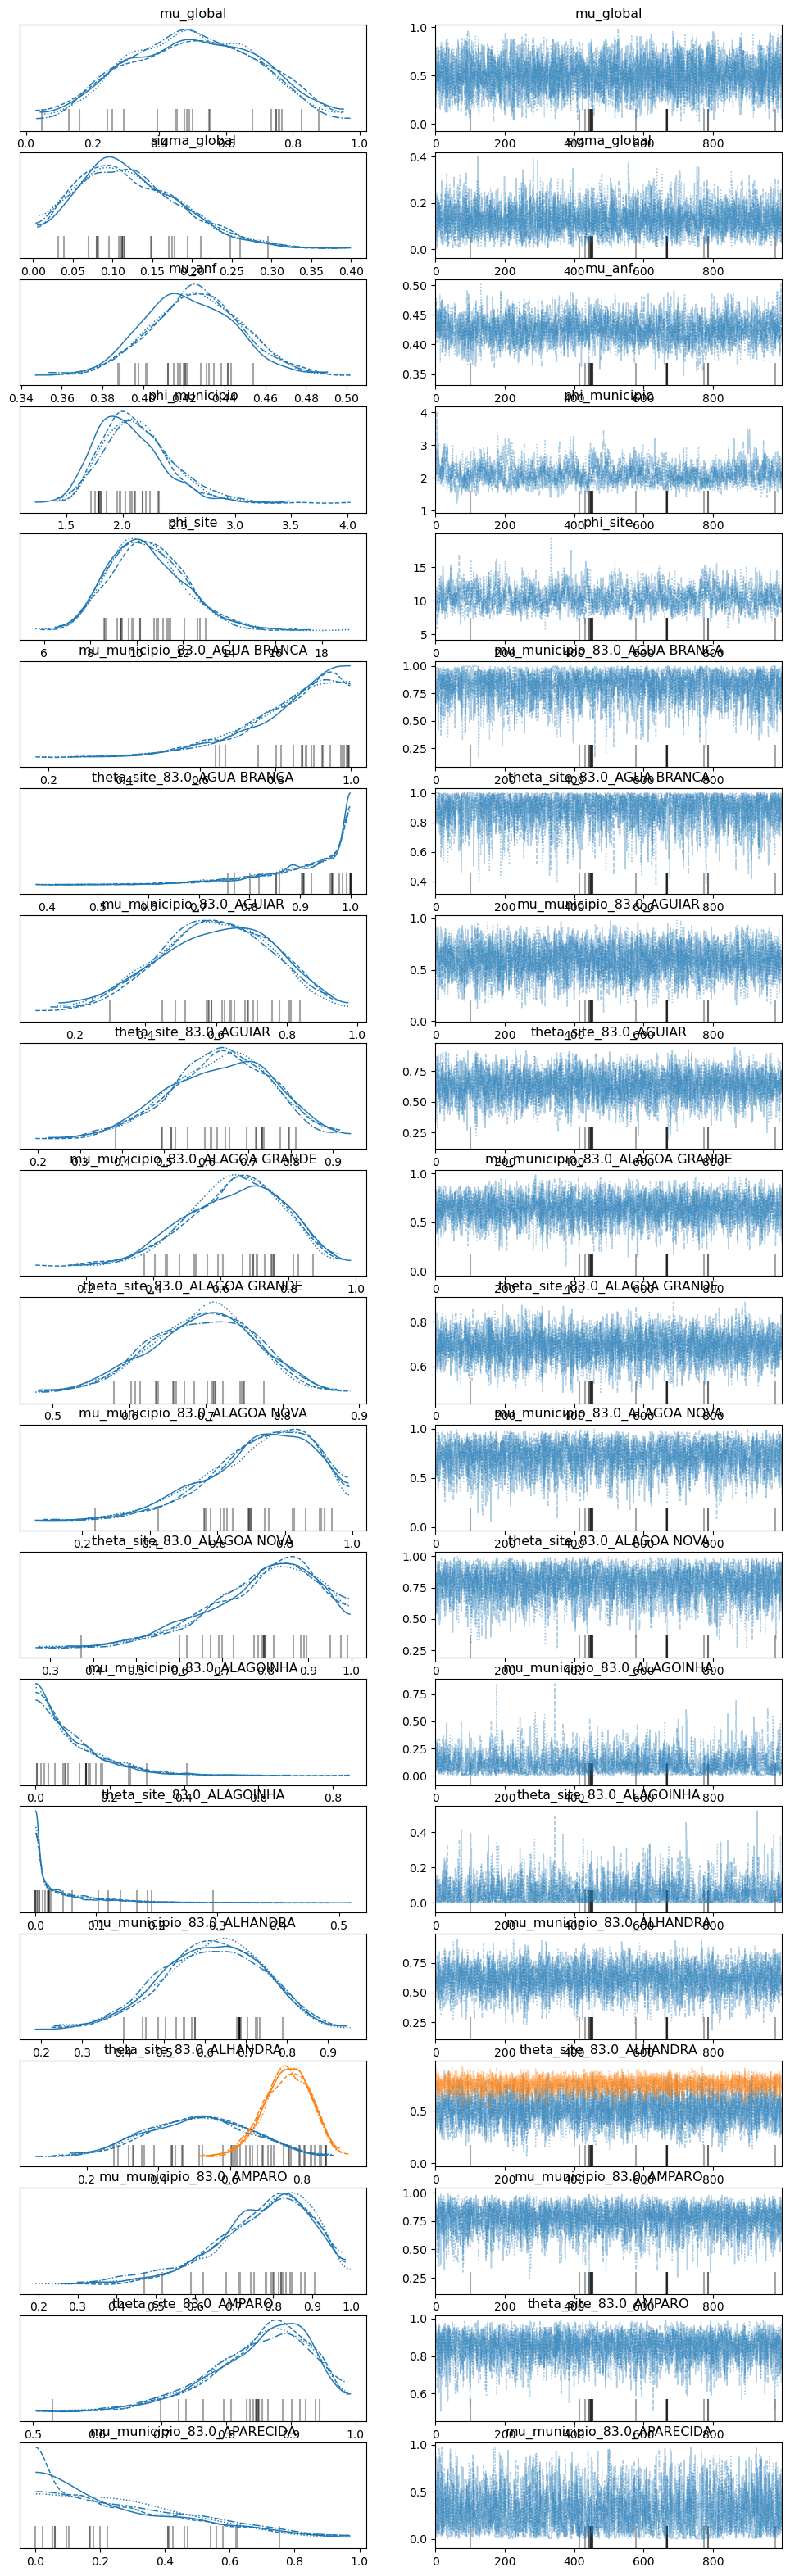

In [5]:
az.summary(trace)  # Verifique R-hat (~1.0) e ESS (>100)
az.plot_trace(trace)

Variáveis disponíveis no trace: ['mu_anf', 'sigma_anf', 'phi_municipio', 'phi_site', 'mu_municipio_83.0_AGUA BRANCA', 'theta_site_83.0_AGUA BRANCA', 'mu_municipio_83.0_AGUIAR', 'theta_site_83.0_AGUIAR', 'mu_municipio_83.0_ALAGOA GRANDE', 'theta_site_83.0_ALAGOA GRANDE', 'mu_municipio_83.0_ALAGOA NOVA', 'theta_site_83.0_ALAGOA NOVA', 'mu_municipio_83.0_ALAGOINHA', 'theta_site_83.0_ALAGOINHA', 'mu_municipio_83.0_ALCANTIL', 'theta_site_83.0_ALCANTIL', 'mu_municipio_83.0_ALGODAO DE JANDAIRA', 'theta_site_83.0_ALGODAO DE JANDAIRA', 'mu_municipio_83.0_ALHANDRA', 'theta_site_83.0_ALHANDRA', 'mu_municipio_83.0_AMPARO', 'theta_site_83.0_AMPARO', 'mu_municipio_83.0_APARECIDA', 'theta_site_83.0_APARECIDA', 'mu_municipio_83.0_ARACAGI', 'theta_site_83.0_ARACAGI', 'mu_municipio_83.0_ARARA', 'theta_site_83.0_ARARA', 'mu_municipio_83.0_ARARUNA', 'theta_site_83.0_ARARUNA', 'mu_municipio_83.0_AREIA', 'theta_site_83.0_AREIA', 'mu_municipio_83.0_AREIA DE BARAUNAS', 'theta_site_83.0_AREIA DE BARAUNAS', 'mu

array([[<Axes: title={'center': 'mu_anf'}>,
        <Axes: title={'center': 'mu_anf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'phi_municipio'}>,
        <Axes: title={'center': 'phi_municipio'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

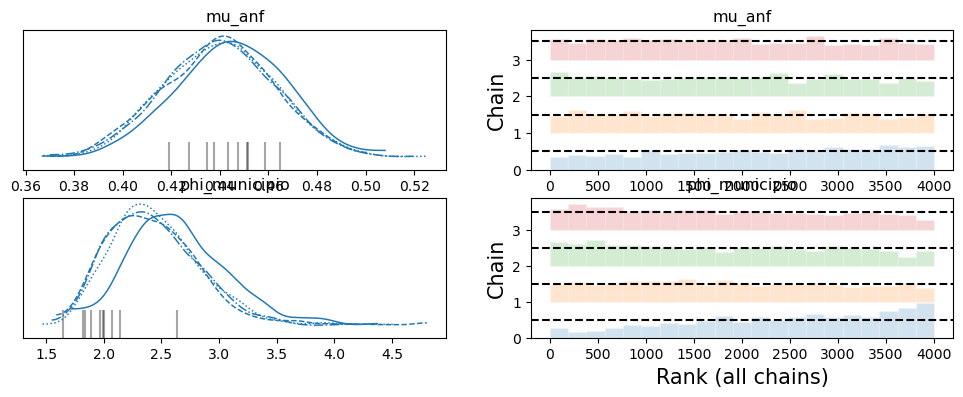

In [11]:
# Listar todas as variáveis disponíveis no trace
print("Variáveis disponíveis no trace:", list(trace.posterior.data_vars))

# Substituir por variáveis válidas presentes no trace
az.plot_trace(
    trace,
    var_names=["mu_anf", "phi_municipio"],  # Substituir por variáveis válidas
    kind="rank_bars"  # Alternar tipo de visualização
)

In [6]:
# Listar todos os parâmetros do modelo
print(list(trace.posterior.data_vars))

['mu_global', 'sigma_global', 'mu_anf', 'phi_municipio', 'phi_site', 'mu_municipio_83.0_AGUA BRANCA', 'theta_site_83.0_AGUA BRANCA', 'mu_municipio_83.0_AGUIAR', 'theta_site_83.0_AGUIAR', 'mu_municipio_83.0_ALAGOA GRANDE', 'theta_site_83.0_ALAGOA GRANDE', 'mu_municipio_83.0_ALAGOA NOVA', 'theta_site_83.0_ALAGOA NOVA', 'mu_municipio_83.0_ALAGOINHA', 'theta_site_83.0_ALAGOINHA', 'mu_municipio_83.0_ALHANDRA', 'theta_site_83.0_ALHANDRA', 'mu_municipio_83.0_AMPARO', 'theta_site_83.0_AMPARO', 'mu_municipio_83.0_APARECIDA', 'theta_site_83.0_APARECIDA', 'mu_municipio_83.0_ARACAGI', 'theta_site_83.0_ARACAGI', 'mu_municipio_83.0_ARARA', 'theta_site_83.0_ARARA', 'mu_municipio_83.0_ARARUNA', 'theta_site_83.0_ARARUNA', 'mu_municipio_83.0_AREIA', 'theta_site_83.0_AREIA', 'mu_municipio_83.0_AREIA DE BARAUNAS', 'theta_site_83.0_AREIA DE BARAUNAS', 'mu_municipio_83.0_AREIAL', 'theta_site_83.0_AREIAL', 'mu_municipio_83.0_AROEIRAS', 'theta_site_83.0_AROEIRAS', 'mu_municipio_83.0_ASSUNCAO', 'theta_site_83.

In [7]:
# Listar todas as variáveis no trace
print(trace.posterior.data_vars)

Data variables:
    mu_global                                         (chain, draw) float64 32kB ...
    sigma_global                                      (chain, draw) float64 32kB ...
    mu_anf                                            (chain, draw, mu_anf_dim_0) float64 32kB ...
    phi_municipio                                     (chain, draw) float64 32kB ...
    phi_site                                          (chain, draw) float64 32kB ...
    mu_municipio_83.0_AGUA BRANCA                     (chain, draw) float64 32kB ...
    theta_site_83.0_AGUA BRANCA                       (chain, draw, theta_site_83.0_AGUA BRANCA_dim_0) float64 32kB ...
    mu_municipio_83.0_AGUIAR                          (chain, draw) float64 32kB ...
    theta_site_83.0_AGUIAR                            (chain, draw, theta_site_83.0_AGUIAR_dim_0) float64 32kB ...
    mu_municipio_83.0_ALAGOA GRANDE                   (chain, draw) float64 32kB ...
    theta_site_83.0_ALAGOA GRANDE                     (

In [8]:
# Listar todos os parâmetros que contêm "theta_site" no nome
var_list = [var for var in trace.posterior.data_vars if "theta_site" in var]

# Filtrar apenas os sites de "CAMPINA GRANDE"
var_list_campina = [var for var in var_list if "JOAO PESSOA" in var]

# Gerar sumário
az.summary(trace, var_names=var_list_campina)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_site_83.0_JOAO PESSOA[0],0.712,0.043,0.627,0.787,0.001,0.001,4932.0,2442.0,1.0
theta_site_83.0_JOAO PESSOA[1],0.734,0.048,0.644,0.819,0.001,0.001,5314.0,2975.0,1.0
theta_site_83.0_JOAO PESSOA[2],0.612,0.059,0.503,0.728,0.001,0.001,7135.0,2727.0,1.0
theta_site_83.0_JOAO PESSOA[3],0.774,0.054,0.667,0.869,0.001,0.001,7854.0,2587.0,1.0
theta_site_83.0_JOAO PESSOA[4],0.682,0.041,0.610,0.757,0.001,0.001,5891.0,2676.0,1.0
...,...,...,...,...,...,...,...,...,...
theta_site_83.0_JOAO PESSOA[100],0.848,0.060,0.741,0.954,0.001,0.001,4033.0,2274.0,1.0
theta_site_83.0_JOAO PESSOA[101],0.684,0.065,0.563,0.806,0.001,0.001,5489.0,2143.0,1.0
theta_site_83.0_JOAO PESSOA[102],0.760,0.028,0.707,0.810,0.000,0.001,5556.0,2529.0,1.0
theta_site_83.0_JOAO PESSOA[103],0.805,0.065,0.686,0.922,0.001,0.001,6574.0,2626.0,1.0
